In [1]:
import os
import json
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
# %matplotlib inline
# from IPython.display import set_matplotlib_formats
from matplotlib.colors import to_rgb
import matplotlib
# matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader

from scipy import linalg

In [2]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


Dataset loaded. Number of images: 39209. Number of classes: 43


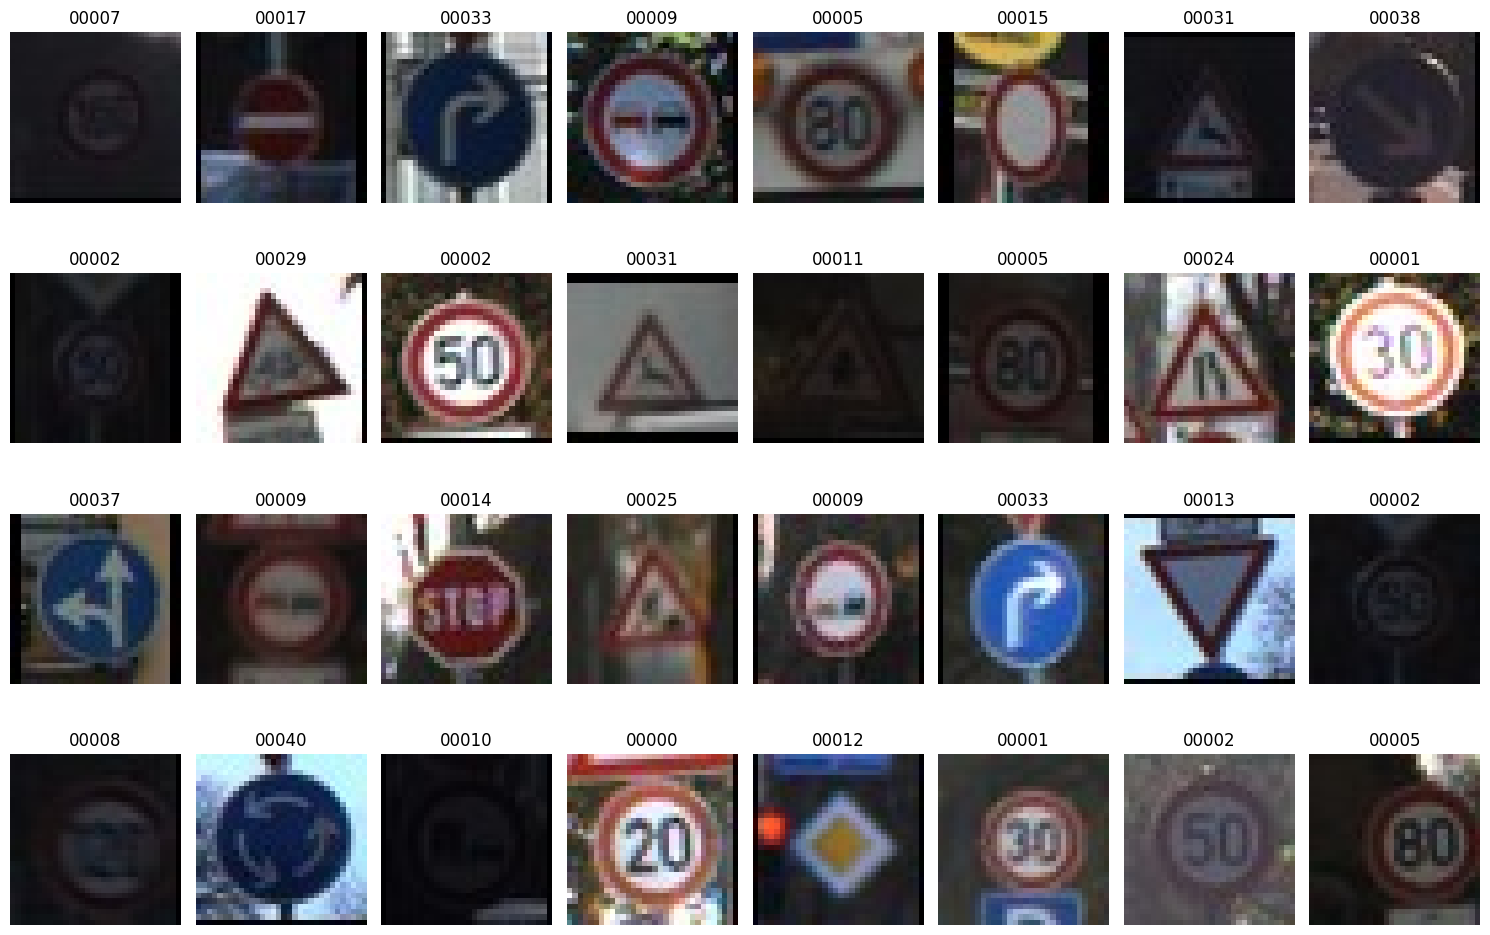

In [ ]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size_data = 32

dataset = ImageFolder("trafic_32", transform=transform)
print(f"Dataset loaded. Number of images: {len(dataset)}. Number of classes: {len(dataset.classes)}")

train_size = int(len(dataset) * 0.8)
if train_size == 0 and len(dataset) > 0 : train_size = len(dataset)
valid_size = len(dataset) - train_size

if valid_size == 0 and train_size > 0:
    print("Warning: No validation set. Using training set for validation purposes.")
    train_subset, valid_subset = random_split(dataset, [train_size, valid_size]) if valid_size > 0 else (dataset, dataset)

else:
    train_subset, valid_subset = random_split(dataset, [train_size, valid_size])


train_loader = DataLoader(train_subset, batch_size=batch_size_data, shuffle=True, num_workers=2, pin_memory=True)
valid_loader_eval = DataLoader(valid_subset, batch_size=batch_size_data, shuffle=False, num_workers=2, pin_memory=True) 

all_valid_loader_for_fid = DataLoader(valid_subset, batch_size=len(valid_subset) if len(valid_subset)>0 else 1, shuffle=False)

class_names = dataset.classes
data_iter = iter(train_loader)
images, labels = next(data_iter)
images_display = images * 0.5 + 0.5

fig, axes = plt.subplots(4, 8, figsize=(15, 10))
axes = axes.flatten()
for img, label, ax in zip(images_display[:32], labels[:32], axes):
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(class_names[label])
    ax.axis("off")
for ax_idx in range(len(images_display[:32]), len(axes)):
    axes[ax_idx].axis("off")
plt.tight_layout()
plt.show()

In [ ]:
def corrupt(x, amount):
    noise = (torch.rand_like(x) * 2) - 1
    amount = amount.view(-1, 1, 1, 1)
    return x * (1 - amount) + noise * amount

In [ ]:
class BasicUNet(nn.Module):
    """An improved UNet implementation for 32x32 3-channel images."""
    def __init__(self, in_channels=3, out_channels=3, time_emb_dim=64):
        super().__init__()
        self.time_emb_dim = time_emb_dim

        self.time_mlp = nn.Sequential(
            nn.Linear(1, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )

        self.down1_conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.down1_bn1 = nn.BatchNorm2d(64)
        self.down1_conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.down1_bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2)

        self.down2_conv1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.down2_bn1 = nn.BatchNorm2d(128)
        self.down2_conv2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.down2_bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck_conv1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bottleneck_bn1 = nn.BatchNorm2d(256)
        self.bottleneck_conv2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bottleneck_bn2 = nn.BatchNorm2d(256)
        
        self.time_proj_up2 = nn.Linear(time_emb_dim, 128) 
        self.time_proj_up1 = nn.Linear(time_emb_dim, 64)  


        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up2_conv1 = nn.Conv2d(256, 128, kernel_size=3, padding=1) 
        self.up2_bn1 = nn.BatchNorm2d(128)
        self.up2_conv2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.up2_bn2 = nn.BatchNorm2d(128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up1_conv1 = nn.Conv2d(128, 64, kernel_size=3, padding=1) 
        self.up1_bn1 = nn.BatchNorm2d(64)
        self.up1_conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.up1_bn2 = nn.BatchNorm2d(64)

        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        self.act = nn.SiLU()


    def forward(self, x, t):
        time_embedding = self.time_mlp(t.unsqueeze(-1)) 

        x1 = self.act(self.down1_bn1(self.down1_conv1(x)))
        x1 = self.act(self.down1_bn2(self.down1_conv2(x1)))
        p1 = self.pool1(x1)

        x2 = self.act(self.down2_bn1(self.down2_conv1(p1)))
        x2 = self.act(self.down2_bn2(self.down2_conv2(x2)))
        p2 = self.pool2(x2)

        bottleneck_out = self.act(self.bottleneck_bn1(self.bottleneck_conv1(p2)))
        bottleneck_out = self.act(self.bottleneck_bn2(self.bottleneck_conv2(bottleneck_out)))

        up2_out = self.upconv2(bottleneck_out)
        t_emb_for_x2 = self.time_proj_up2(time_embedding)
        t_emb_for_x2_reshaped = t_emb_for_x2.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, x2.size(2), x2.size(3))
        up2_combined = torch.cat([up2_out, x2 + t_emb_for_x2_reshaped], dim=1)
        up2_final = self.act(self.up2_bn1(self.up2_conv1(up2_combined)))
        up2_final = self.act(self.up2_bn2(self.up2_conv2(up2_final)))

        up1_out = self.upconv1(up2_final)
        t_emb_for_x1 = self.time_proj_up1(time_embedding)
        t_emb_for_x1_reshaped = t_emb_for_x1.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, x1.size(2), x1.size(3))
        up1_combined = torch.cat([up1_out, x1 + t_emb_for_x1_reshaped], dim=1)
        up1_final = self.act(self.up1_bn1(self.up1_conv1(up1_combined)))
        up1_final = self.act(self.up1_bn2(self.up1_conv2(up1_final)))
        
        output = self.out_conv(up1_final)
        return output

In [8]:
n_epochs_diffusion = 90
diffusion_net = BasicUNet(in_channels=3, out_channels=3, time_emb_dim=64).to(device)

num_params = sum(p.numel() for p in diffusion_net.parameters() if p.requires_grad)
print(f"Number of parameters in the new U-Net: {num_params}")

loss_fn_diffusion = nn.MSELoss()
opt_diffusion = torch.optim.Adam(diffusion_net.parameters(), lr=1e-4)
scheduler_diffusion = torch.optim.lr_scheduler.StepLR(opt_diffusion, step_size=25, gamma=0.7)

losses_diffusion = []

Number of parameters in the new U-Net: 1882307


In [9]:
print("\n--- Training Diffusion Model (Improved U-Net) ---")
for epoch in range(n_epochs_diffusion):
    epoch_loss_sum = 0
    diffusion_net.train()
    for x_batch, _ in train_loader:
        x_batch = x_batch.to(device)
        noise_amount_t = torch.rand(x_batch.shape[0]).to(device) 
        
        noisy_x = corrupt(x_batch, noise_amount_t)
        pred_x0 = diffusion_net(noisy_x, noise_amount_t)
        
        loss = loss_fn_diffusion(pred_x0, x_batch) 
        
        opt_diffusion.zero_grad()
        loss.backward()
        opt_diffusion.step()
        
        losses_diffusion.append(loss.item())
        epoch_loss_sum += loss.item()

    scheduler_diffusion.step()
    avg_loss_epoch = epoch_loss_sum / len(train_loader)
    current_lr = opt_diffusion.param_groups[0]['lr']
    print(f'Finished diffusion epoch {epoch+1}/{n_epochs_diffusion}. Avg loss: {avg_loss_epoch:.6f}. LR: {current_lr:.1e}')


--- Training Diffusion Model (Improved U-Net) ---


Finished diffusion epoch 1/90. Avg loss: 0.083299. LR: 1.0e-04
Finished diffusion epoch 2/90. Avg loss: 0.052854. LR: 1.0e-04
Finished diffusion epoch 3/90. Avg loss: 0.049660. LR: 1.0e-04
Finished diffusion epoch 4/90. Avg loss: 0.047388. LR: 1.0e-04
Finished diffusion epoch 5/90. Avg loss: 0.045663. LR: 1.0e-04
Finished diffusion epoch 6/90. Avg loss: 0.043491. LR: 1.0e-04
Finished diffusion epoch 7/90. Avg loss: 0.042317. LR: 1.0e-04
Finished diffusion epoch 8/90. Avg loss: 0.040438. LR: 1.0e-04
Finished diffusion epoch 9/90. Avg loss: 0.040000. LR: 1.0e-04
Finished diffusion epoch 10/90. Avg loss: 0.038993. LR: 1.0e-04
Finished diffusion epoch 11/90. Avg loss: 0.037321. LR: 1.0e-04
Finished diffusion epoch 12/90. Avg loss: 0.036269. LR: 1.0e-04
Finished diffusion epoch 13/90. Avg loss: 0.036269. LR: 1.0e-04
Finished diffusion epoch 14/90. Avg loss: 0.035444. LR: 1.0e-04
Finished diffusion epoch 15/90. Avg loss: 0.034777. LR: 1.0e-04
Finished diffusion epoch 16/90. Avg loss: 0.03427

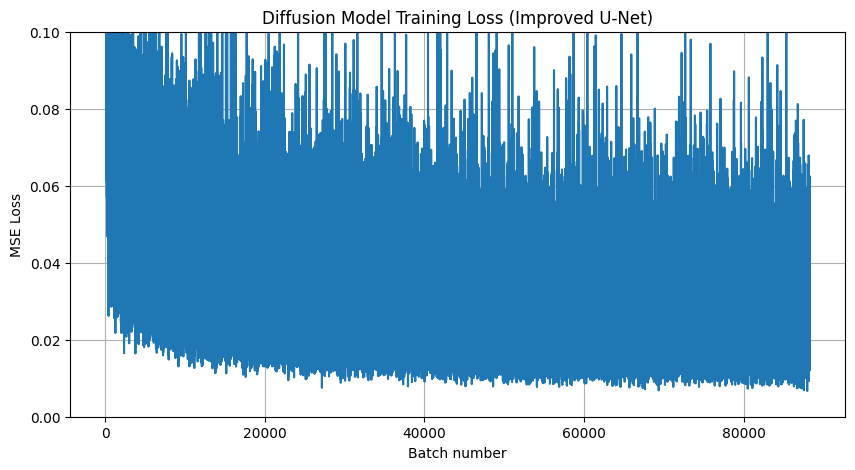

In [10]:
plt.figure(figsize=(10,5))
plt.plot(losses_diffusion)
plt.title("Diffusion Model Training Loss (Improved U-Net)")
plt.xlabel("Batch number")
plt.ylabel("MSE Loss")
plt.ylim(0, max(0.1, np.percentile(losses_diffusion,99) if losses_diffusion else 0.1) )
plt.grid(True)
plt.show()


--- Generating 64 new images using 250 steps (Improved U-Net) ---
Sampling step 12/250
Sampling step 24/250
Sampling step 36/250
Sampling step 48/250
Sampling step 60/250
Sampling step 72/250
Sampling step 84/250
Sampling step 96/250
Sampling step 108/250
Sampling step 120/250
Sampling step 132/250
Sampling step 144/250
Sampling step 156/250
Sampling step 168/250
Sampling step 180/250
Sampling step 192/250
Sampling step 204/250
Sampling step 216/250
Sampling step 228/250
Sampling step 240/250


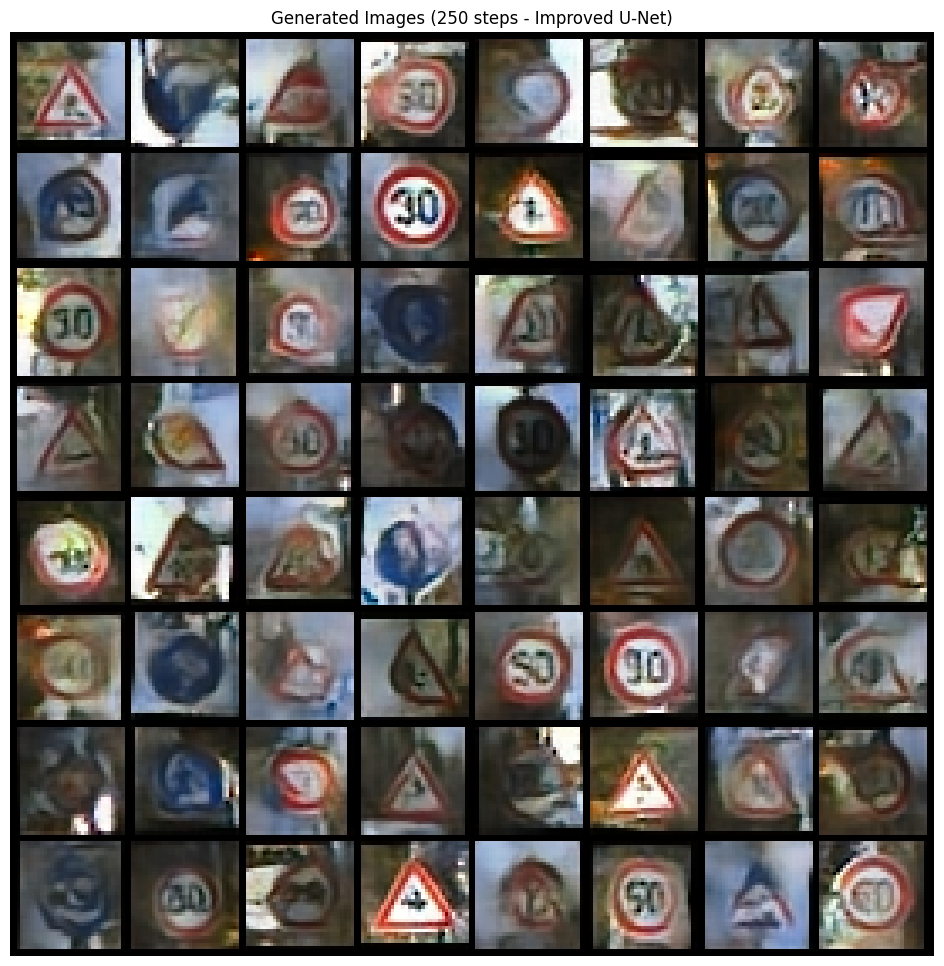

In [11]:
n_sampling_steps = 250
n_generated_samples = 64
x_generated = (torch.rand(n_generated_samples, 3, 32, 32) * 2 - 1).to(device)

print(f"\n--- Generating {n_generated_samples} new images using {n_sampling_steps} steps (Improved U-Net) ---")
diffusion_net.eval()
for i in range(n_sampling_steps):
    t_for_network = (torch.ones(x_generated.size(0)) * (n_sampling_steps - 1 - i) / n_sampling_steps).to(device)
    
    with torch.no_grad():
        pred_x0 = diffusion_net(x_generated, t_for_network) 
    
    mix_factor = 1.0 / (n_sampling_steps - i) if (n_sampling_steps - i) > 0 else 1.0
    mix_factor = min(mix_factor, 1.0) 
        
    x_generated = pred_x0 * mix_factor + x_generated * (1 - mix_factor)
    
    if (i+1) % (n_sampling_steps // 20 or 1) == 0:
            print(f"Sampling step {i+1}/{n_sampling_steps}")

# Wyświetlanie po samplowaniu
x_generated_display = (x_generated.detach().cpu() * 0.5 + 0.5).clip(0,1)
fig_gen, ax_gen = plt.subplots(1, 1, figsize=(12, 12))
ax_gen.imshow(torchvision.utils.make_grid(x_generated_display, nrow=8).permute(1, 2, 0))
ax_gen.set_title(f'Generated Images ({n_sampling_steps} steps - Improved U-Net)')
ax_gen.axis('off')
plt.show()

In [12]:
n_sampling_steps = 250
n_generated_samples = 1000
image_channels = 3
image_size = 32

x_generated_for_fid = (torch.rand(n_generated_samples, image_channels, image_size, image_size) * 2 - 1).to(device)
diffusion_net.eval()

for i in range(n_sampling_steps):
    with torch.no_grad():
        t_for_network = (torch.ones(x_generated_for_fid.size(0)) * (n_sampling_steps - 1 - i) / n_sampling_steps).to(device)
        pred_x0 = diffusion_net(x_generated_for_fid, t_for_network) 
    
    mix_factor = 1.0 / (n_sampling_steps - i) if (n_sampling_steps - i) > 0 else 1.0
    mix_factor = min(mix_factor, 1.0)
    x_generated_for_fid = pred_x0 * mix_factor + x_generated_for_fid * (1 - mix_factor)
    
    if (i+1) % (n_sampling_steps // 10 or 1) == 0:
        print(f"Sampling step {i+1}/{n_sampling_steps}")

generations_diff = x_generated_for_fid.detach().cpu()

Sampling step 25/250
Sampling step 50/250
Sampling step 75/250
Sampling step 100/250
Sampling step 125/250
Sampling step 150/250
Sampling step 175/250
Sampling step 200/250
Sampling step 225/250
Sampling step 250/250


In [13]:
orig_data = torch.stack([x[0] for x in list(valid_subset)[:1000]])
orig_data = orig_data.view(-1, 3*32*32)

In [14]:
from evaluator import Evaluator

device = torch.device("cuda")


evaluator = Evaluator(3*32*32, 512).to(device)
evaluator.load_state_dict(torch.load("evaluator.pth"))
evaluator.eval()

with torch.no_grad():
    dist_orig_data = evaluator.get_features(orig_data.to(device)).cpu()
    dist_diff = evaluator.get_features(generations_diff.to(device)).cpu()

In [15]:
from fid import calculate_frechet_distance

for name, obj in zip(['orig','diff'],[dist_orig_data.numpy(),dist_diff.numpy()]):
    print(f"FD {name}: {calculate_frechet_distance(dist_orig_data.numpy(),obj)}")

FD orig: -7.09405867382884e-10
FD diff: 2142.7989285268377


In [1]:
torch.save(diffusion_net.state_dict(), "diff.pth")
torch.save(generations_diff.cpu().detach(),"piatek_Bagnowski_Lenczewski.pt")

NameError: name 'torch' is not defined